In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/final_dataset.csv")

<ipython-input-22-3d1d768844d3>:1: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/final_dataset.csv")


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152552 entries, 0 to 152551
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   HHID                             152552 non-null  int64  
 1   Per_serialno                     152552 non-null  float64
 2   Sector                           152552 non-null  int64  
 3   HH_Computer                      152552 non-null  int64  
 4   Member_internet                  152552 non-null  int64  
 5   HH_Con_exp_rs                    152552 non-null  int64  
 6   Any_HH_member_3_35yrs_attnd_edu  152552 non-null  int64  
 7   Scholarship_stipend              152552 non-null  float64
 8   Age                              122931 non-null  float64
 9   Gender                           122931 non-null  float64
 10  Operate_computer_age_5yrs        120695 non-null  float64
 11  Operate_internet_age_5yrs        120695 non-null  float64
 12  Di

In [ ]:
# List of categorical columns
categorical_cols = [
    'HH_Computer', 'Member_internet', 'Any_HH_member_3_35yrs_attnd_edu',
    'Scholarship_stipend', 'Taking_pvt_coaching', 'Operate_computer_age_5yrs',
    'Operate_internet_age_5yrs', 'Disability_crtificate',
    'Household_size_category', 'HH_Economic_Activity_category', 'Religion_category',
    'Social_Group_Category', 'Distance_primary_category', 'Distance_upper_category',
    'Distance_secondary_category', 'Medium_instruction_grouped', 'Enrol_basic_course_grouped',
    'Edu_level_general_category', 'Edu_level_technical_category', 'Institution_category',"Sector","Gender","Funding_Category"
]

# Convert all to categorical
df[categorical_cols] = df[categorical_cols].astype('category')

#Making changes in the dataset using the EDA results

##dropping columns with no predictive power

In [ ]:
df = df.drop(columns = ["Per_serialno","HHID"])
#df = df.drop(columns =["Gender","Disability_crtificate","Member_internet","Any_HH_member_3_35yrs_attnd_edu","Operate_internet_age_5yrs"])

In [ ]:
#df['Total_edu_exp'] = df['Course_fee_amt'] + df['Books_stationery_uniform_amt']
#df = df.drop(columns = ["Course_fee_amt","Books_stationery_uniform_amt"])

## log tranformation of excessively skewed variables

In [ ]:
#df['Total_edu_exp'] = np.log1p(df['Total_edu_exp'])
df['HH_Con_exp_rs_log'] = np.log1p(df['HH_Con_exp_rs'])
df['Course_fee_amt_log'] = np.log1p(df['Course_fee_amt'])
df['Books_stationery_uniform_amt_log'] = np.log1p(df['Books_stationery_uniform_amt'])

df = df.drop(columns = ["HH_Con_exp_rs","Course_fee_amt","Books_stationery_uniform_amt"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152552 entries, 0 to 152551
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   Sector                            152552 non-null  category
 1   HH_Computer                       152552 non-null  category
 2   Member_internet                   152552 non-null  category
 3   Any_HH_member_3_35yrs_attnd_edu   152552 non-null  category
 4   Scholarship_stipend               152552 non-null  category
 5   Age                               122931 non-null  float64 
 6   Gender                            122931 non-null  category
 7   Operate_computer_age_5yrs         120695 non-null  category
 8   Operate_internet_age_5yrs         120695 non-null  category
 9   Disability_crtificate             122931 non-null  category
 10  Household_size_category           152552 non-null  category
 11  HH_Economic_Activity_category     15255

#Model Building

##Baseline Model

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Taking_pvt_coaching', axis=1)
y = df['Taking_pvt_coaching']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [ ]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.8202


#Classification Models

##Scaling/encoding/imputing

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Define columns
ordinal_cols = ['Household_size_category', 'Edu_level_general_category',
                'Distance_primary_category', 'Distance_upper_category',
                'Distance_secondary_category', 'Edu_level_technical_category']

ordinal_categories = [
    ['Small', 'Medium', 'Large', 'Very Large'],
    ['Low Education', 'Basic Education', 'Secondary Education', 'Higher Education', 'Diploma Holders'],
    ['Nearby', 'Moderate Distance', 'Far'],
    ['Nearby', 'Moderate Distance', 'Far'],
    ['Nearby', 'Moderate Distance', 'Far'],
    ['No Technical Education', 'Technical Diploma & Degree']
]

nominal_cols = ['HH_Economic_Activity_category', 'Religion_category',
                'Social_Group_Category', 'Medium_instruction_grouped',
                'Enrol_basic_course_grouped', 'Institution_category',
                'State_Category', 'Funding_Category','Sector',
                "Gender","Disability_crtificate","Member_internet",
                "Any_HH_member_3_35yrs_attnd_edu","Operate_internet_age_5yrs"]

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Pipelines
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=ordinal_categories))
])

nominal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore',drop = "first"))
])

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # For models that need it
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('ordinal', ordinal_pipeline, ordinal_cols),
    ('nominal', nominal_pipeline, nominal_cols),
    ('num', numeric_pipeline, numerical_cols)
])


##checking for multicollinearity among all variables after encoding, scaling & imputing

In [ ]:
X_processed = preprocessor.fit_transform(X)


In [ ]:
import numpy as np

# Ordinal names (already 1:1)
ordinal_features = ordinal_cols

# Nominal names (get one-hot encoded column names)
nominal_features = preprocessor.named_transformers_['nominal']\
    .named_steps['encoder'].get_feature_names_out(nominal_cols)

# Numerical names
numerical_features = list(numerical_cols)

# Combine all
all_features = np.concatenate([ordinal_features, nominal_features, numerical_features])


In [ ]:
import pandas as pd

X_df = pd.DataFrame(X_processed, columns=all_features)


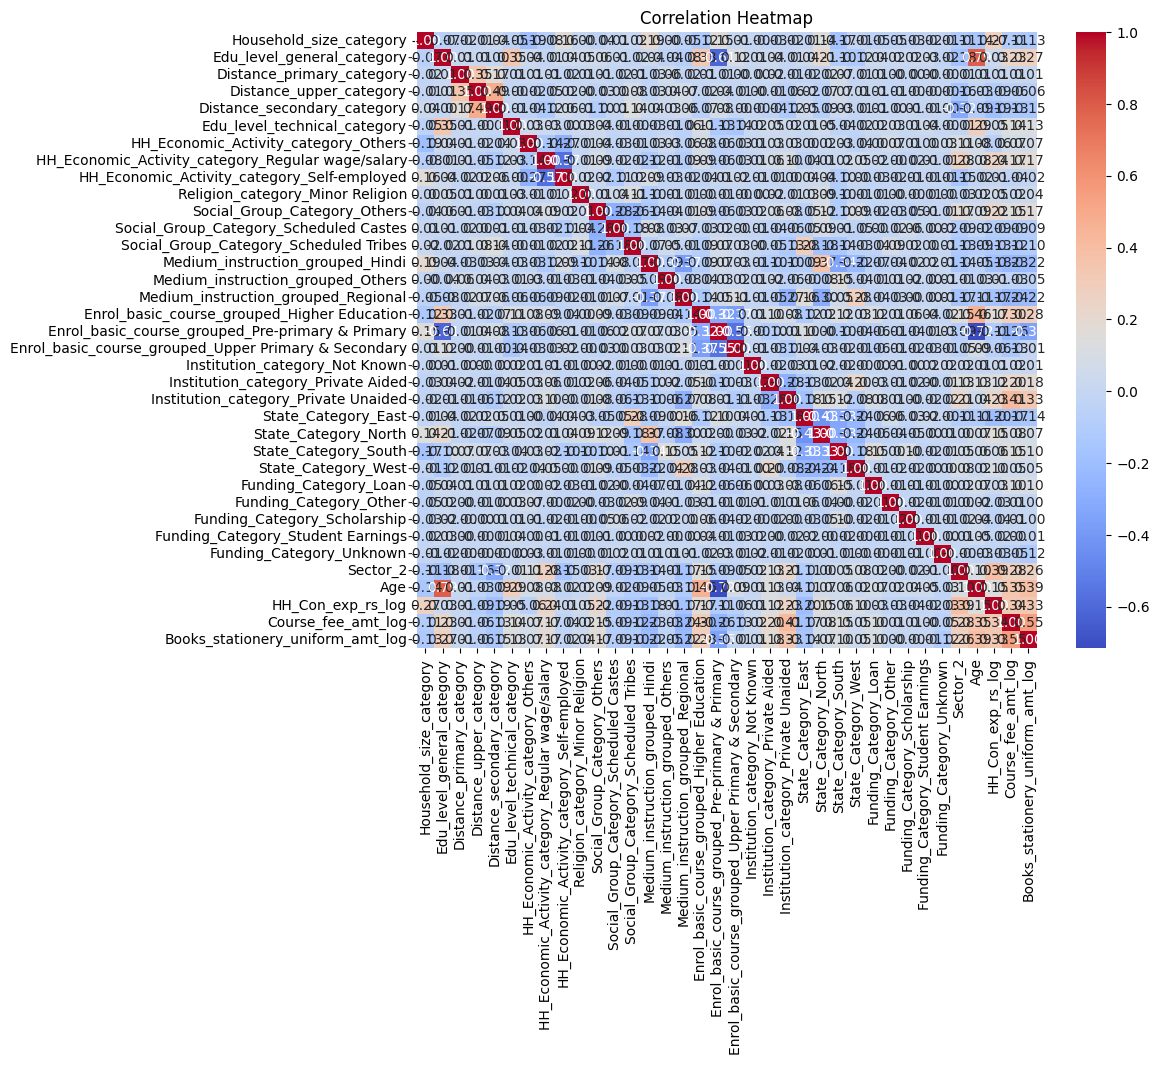

In [ ]:
import seaborn as sns
correlation_matrix = X_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]


In [ ]:
vif_data.sort_values(by="VIF", ascending=False)

,feature,VIF
1,Edu_level_general_category,9.383775
17,Enrol_basic_course_grouped_Pre-primary & Primary,7.210919
0,Household_size_category,6.637619
18,Enrol_basic_course_grouped_Upper Primary & Sec...,5.011114
37,Age,4.947848
23,State_Category_North,4.869719
22,State_Category_East,4.801376
8,HH_Economic_Activity_category_Self-employed,3.894603
36,Operate_internet_age_5yrs_1.0,3.492136
24,State_Category_South,3.248365


In [ ]:
high_vif_cols = ['Edu_level_general_category', 'Enrol_basic_course_grouped_Pre-primary & Primary', 'Household_size_category']
X_df[high_vif_cols].corr()

,Edu_level_general_category,Enrol_basic_course_grouped_Pre-primary & Primary,Household_size_category
Edu_level_general_category,1.000000,-0.612916,-0.070311
Enrol_basic_course_grouped_Pre-primary & Primary,-0.612916,1.000000,0.149592
Household_size_category,-0.070311,0.149592,1.000000


#Random Forest with Random OverSampling

##b4 removing high vif columns from the data

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler # Correct import statement
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Example with Random Forest + SMOTE
model_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('oversample', RandomOverSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np

# Stratified CV to preserve class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter space
param_dist = {
    'preprocess__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_estimators': np.arange(50, 201, 50),
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [5,10],
    'classifier__min_samples_leaf': [4,6],
    'classifier__max_features': ['sqrt'],
    'classifier__bootstrap': [True]
}

# Randomized search
rf = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit search
rf.fit(X_train, y_train)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('ordinal',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OrdinalEncoder(categories=[['Small',
                                                                                                                            'Medium',
                                                                                                                            'Large',
                                                                                                                            'Very '
                                                                                                                            'Large'],
                                                                                                                           ['Low '
                                                                                                                            'Education',
                                                                                                                            'Basic '
                                                                                                                            'Education',
                                                                                                                            'Sec...
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True],
                                        'classifier__max_depth': [5, 10, 15],
                                        'classifier__max_features': ['sqrt'],
                                        'classifier__min_samples_leaf': [4, 6],
                                        'classifier__min_samples_split': [5,
                                                                          10],
                                        'classifier__n_estimators': array([ 50, 100, 150, 200]),
                                        'preprocess__num__imputer__strategy': ['mean',
                                                                               'median']},
                   random_state=42, scoring='f1', verbose=1)

In [ ]:


y_probs = rf.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (positive class)
threshold = 0.6030
y_pred = (y_probs >= threshold).astype(int)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", round(acc, 4))

#training accuracy
y_pred_train = rf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", round(acc_train, 4))

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", round(precision, 4))

#training precision
y_pred_train = rf.predict(X_train)
precision_train = precision_score(y_train, y_pred_train)
print("Training Precision:", round(precision_train, 4))

#calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", round(recall, 4))

#training recall
recall_train = recall_score(y_train, y_pred_train)
print("Training Recall:", round(recall_train, 4))


# calculate f1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", round(f1, 4))

#training f1 score
f1_train = f1_score(y_train, y_pred_train)
print("Training F1 Score:", round(f1_train, 4))

#calculate AUC-ROC
y_pred_proba = rf.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC:", round(auc_roc, 4))



Test Accuracy: 0.8297
Training Accuracy: 0.8298
Precision: 0.5227
Training Precision: 0.5162
Recall: 0.6088
Training Recall: 0.8486
F1 Score: 0.5625
Training F1 Score: 0.6419
AUC-ROC: 0.8503


In [ ]:
rf.best_params_

{'preprocess__num__imputer__strategy': 'median',
 'classifier__n_estimators': np.int64(150),
 'classifier__min_samples_split': 5,
 'classifier__min_samples_leaf': 4,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 15,
 'classifier__bootstrap': True}

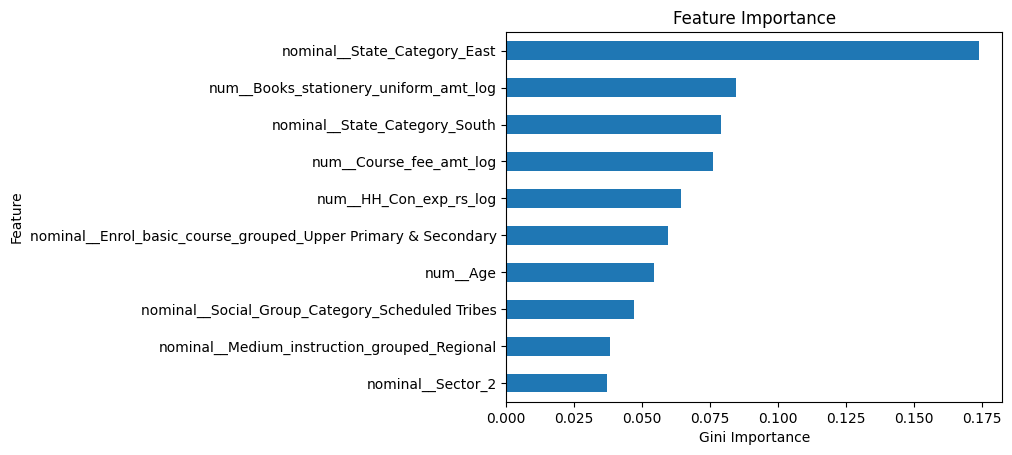

In [ ]:

# Get feature names after transformation
preprocessor = rf.best_estimator_.named_steps["preprocess"]
feature_names = preprocessor.get_feature_names_out()

# Extract importances from model
importances = rf.best_estimator_.named_steps["classifier"].feature_importances_

# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=feature_names)

# Plot 10 most important features
feat_imp.sort_values().tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [ ]:
feat_imp.sort_values().tail(10)

,0
num__Age,0.040170
num__Course_fee_amt_log,0.045010
nominal__Sector_2,0.054199
nominal__State_Category_North,0.055901
nominal__Medium_instruction_grouped_Regional,0.056759
nominal__Social_Group_Category_Scheduled Tribes,0.062301
num__Books_stationery_uniform_amt_log,0.071130
nominal__Enrol_basic_course_grouped_Upper Primary & Secondary,0.092760
nominal__State_Category_South,0.109272
nominal__State_Category_East,0.227037


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Best Threshold: 0.6030
F1 Score at Best Threshold: 0.5656
Precision: 0.5223
Recall: 0.6167


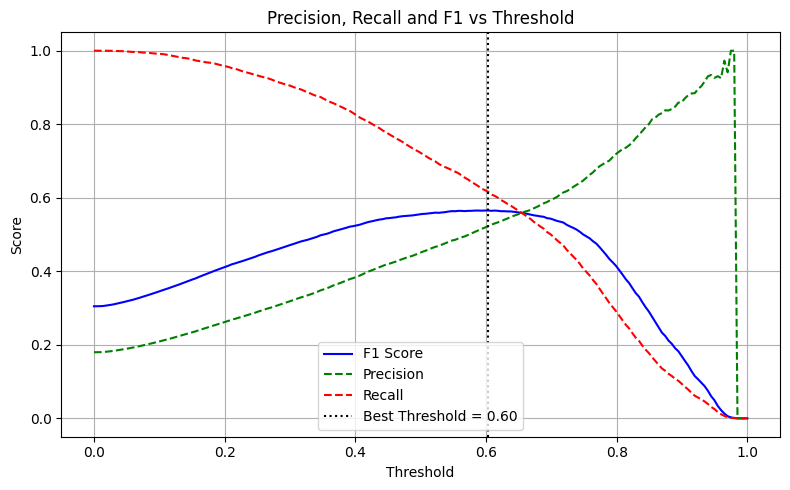

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have:
# y_test = true labels
# y_probs = predicted probabilities (e.g., from model.predict_proba(X_test)[:, 1])

# Create an array of thresholds to test
thresholds = np.linspace(0, 1, 200)
f1_scores = []
precisions = []
recalls = []

# Evaluate F1 at each threshold
for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

# Get the threshold with the best F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best Threshold: {best_threshold:.4f}")
print(f"F1 Score at Best Threshold: {f1_scores[best_idx]:.4f}")
print(f"Precision: {precisions[best_idx]:.4f}")
print(f"Recall: {recalls[best_idx]:.4f}")

# Plot F1 vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1 Score', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='green', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', color='red', linestyle='--')
plt.axvline(best_threshold, color='black', linestyle=':', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall and F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final predictions using best threshold
y_pred_final = (y_probs >= best_threshold).astype(int)

#Logistic Regression with Random Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler # Correct import statement
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression

model_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('oversample', RandomOverSampler(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_grid = [{
        'classifier__penalty': ['l1'],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['saga', 'liblinear']
    },
    {
        'classifier__penalty': ['l2'],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['saga', 'liblinear', 'lbfgs']
    },
    {
        'classifier__penalty': ['elasticnet'],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['saga'],
        'classifier__l1_ratio': [0.5, 1]
    }]

logistic = RandomizedSearchCV(
    estimator=model_pipeline,  # your random forest estimator
    param_distributions=param_grid,
    n_iter=50,  # Number of random combinations to try
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,  # Use all processors for parallelization
    random_state=42
)
# Fit the random search to the data
logistic.fit(X_train, y_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 28 is smaller than n_iter=50. Running 28 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
y_probs = logistic.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (positive class)
threshold = 0.6131
y_pred = (y_probs >= threshold).astype(int)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", round(acc, 4))

#train accuracy
y_pred_train = logistic.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", round(acc_train, 4))

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", round(precision, 4))

#
y_pred_train = logistic.predict(X_train)
precision_train = precision_score(y_train, y_pred_train)
print("Training Precision:", round(precision_train, 4))
#calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", round(recall, 4))

#training recall
recall_train = recall_score(y_train, y_pred_train)
print("Training Recall:", round(recall_train, 4))


# calculate f1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", round(f1, 4))

#training f1 score
f1_train = f1_score(y_train, y_pred_train)
print("Training F1 Score:", round(f1_train, 4))

#calculate AUC-ROC
y_pred_proba = logistic.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC:", round(auc_roc, 4))

#train AUC
y_pred_proba_train = logistic.predict_proba(X_train)[:, 1]
auc_roc_train = roc_auc_score(y_train, y_pred_proba_train)


Test Accuracy: 0.7989
Training Accuracy: 0.7343
Precision: 0.4558
Training Precision: 0.3764
Recall: 0.6105
Training Recall: 0.7277
F1 Score: 0.5219
Training F1 Score: 0.4961
AUC-ROC: 0.8063


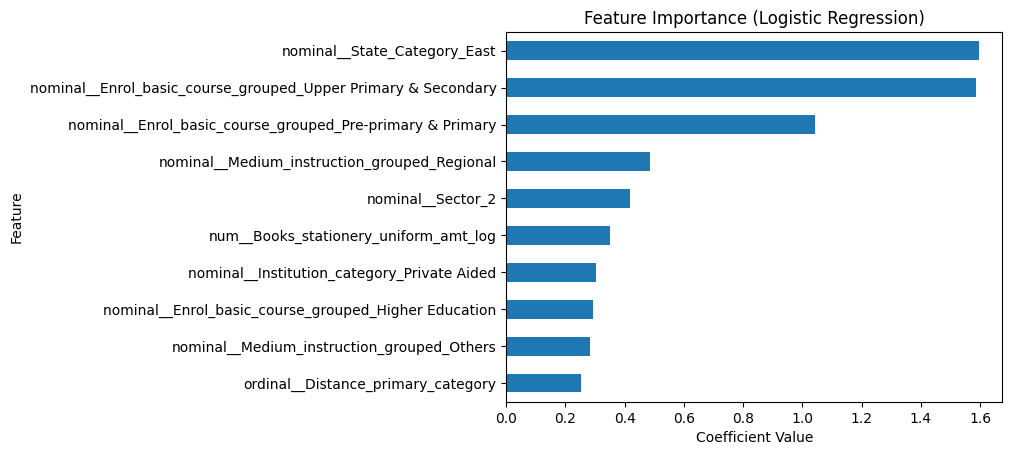

In [ ]:

# Get feature names after transformation
preprocessor = logistic.best_estimator_.named_steps["preprocess"]
feature_names = preprocessor.get_feature_names_out()

# Extract coefficients from the Logistic Regression model
importances = logistic.best_estimator_.named_steps["classifier"].coef_[0]  # Access coefficients for class 0 (or 1 if binary classification)

# Create a series with feature names and importances (coefficients in this case)
feat_imp = pd.Series(importances, index=feature_names)

# Plot 10 most important features (based on coefficient magnitude)
feat_imp.sort_values().tail(10).plot(kind="barh")
plt.xlabel("Coefficient Value")  # Change label to reflect coefficients
plt.ylabel("Feature")
plt.title("Feature Importance (Logistic Regression)");  # Update title for clarity

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Best Threshold: 0.6131
F1 Score at Best Threshold: 0.5219
Precision: 0.4557
Recall: 0.6105


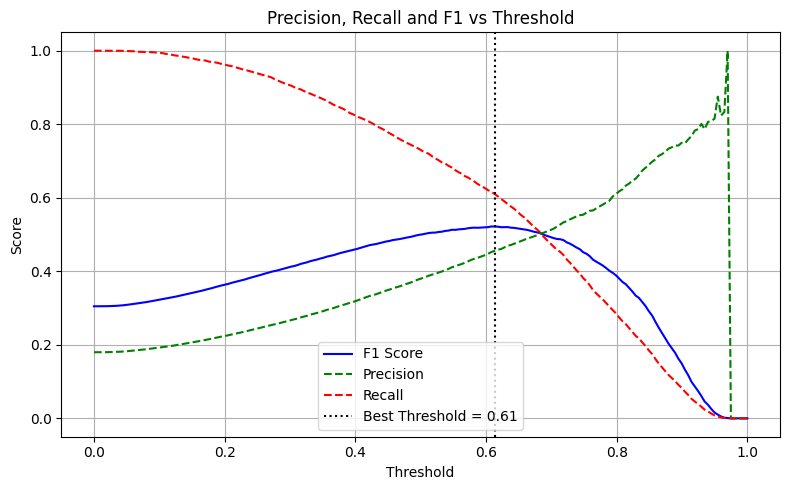

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have:
# y_test = true labels
# y_probs = predicted probabilities (e.g., from model.predict_proba(X_test)[:, 1])

# Create an array of thresholds to test
thresholds = np.linspace(0, 1, 200)
f1_scores = []
precisions = []
recalls = []

# Evaluate F1 at each threshold
for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

# Get the threshold with the best F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best Threshold: {best_threshold:.4f}")
print(f"F1 Score at Best Threshold: {f1_scores[best_idx]:.4f}")
print(f"Precision: {precisions[best_idx]:.4f}")
print(f"Recall: {recalls[best_idx]:.4f}")

# Plot F1 vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1 Score', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='green', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', color='red', linestyle='--')
plt.axvline(best_threshold, color='black', linestyle=':', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall and F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final predictions using best threshold
y_pred_final = (y_probs >= best_threshold).astype(int)

In [ ]:
logistic.best_params_

{'classifier__solver': 'saga',
 'classifier__penalty': 'elasticnet',
 'classifier__l1_ratio': 0.5,
 'classifier__C': 0.01}

In [ ]:
import pandas as pd
import numpy as np

# 1. Get preprocessor and classifier from the best estimator
preprocessor = logistic.best_estimator_.named_steps["preprocess"]
classifier = logistic.best_estimator_.named_steps["classifier"]

# 2. Get transformed feature names
feature_names = preprocessor.get_feature_names_out()

# 3. Extract coefficients and intercept
coefs = classifier.coef_[0]
intercept = classifier.intercept_[0]

# 4. Create a DataFrame for readable mapping
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
})

# 5. Round for neat formatting
coef_df["Coefficient"] = coef_df["Coefficient"].round(4)

# 6. Construct logistic regression equation
terms = [f"({round(coef, 4)} × {name})" for coef, name in zip(coefs, feature_names)]
logit_expression = " + ".join(terms)
logit_full = f"logit(p) = {round(intercept, 4)} + " + logit_expression

# 7. Print outputs
print("\n🔢 Logistic Regression Functional Form:")
print(logit_full)

# Optional: display coefficient table
print("\n📄 Coefficient Table:")
print(coef_df.sort_values(by="Coefficient", ascending=False).reset_index(drop=True))


#Gradient Boosting With Random Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler # Correct import statement
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GradientBoo

# Example with Random Forest + SMOTE
model_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('oversample', RandomOverSampler(random_state=42)),
    ('classifier', GradientBoo(random_state=42))
])


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_grid = {
    'classifier__n_estimators': [100, 150],  # Avoid too few trees
    'classifier__learning_rate': [0.01, 0.05],  # Keep it low to slow down learning
    'classifier__max_depth': [3, 5],  # Limit tree depth to avoid over-complexity
    'classifier__min_samples_split': [5, 10],  # Require more samples to split
    'classifier__min_samples_leaf': [2, 4],  # Larger leaves smooth out learning
    'classifier__subsample': [0.8],  # Introduce randomness for regularization
    'classifier__max_features': ['sqrt', 'log2']  # Limit features per split
}

gb = RandomizedSearchCV(
    estimator=model_pipeline,  # your estimator
    param_distributions=param_grid,
    n_iter=50,  # Number of random combinations to try
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1,  # Use all processors for parallelization
    random_state=42
)
# Fit the random search to the data
gb.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('ordinal',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OrdinalEncoder(categories=[['Small',
                                                                                                                            'Medium',
                                                                                                                            'Large',
                                                                                                                            'Very '
                                                                                                                            'Large'],
                                                                                                                           ['Low '
                                                                                                                            'Education',
                                                                                                                            'Basic '
                                                                                                                            'Education',
                                                                                                                            'Secondary '
                                                                                                                            'Education',
                                                                                                                            'Higher '
                                                                                                                            'Education',
                                                                                                                            'Diploma '
                                                                                                                            'Holder...
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.01,
                                                                      0.05],
                                        'classifier__max_depth': [3, 5],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2'],
                                        'classifier__min_samples_leaf': [2, 4],
                                        'classifier__min_samples_split': [5,
                                                                          10],
                                        'classifier__n_estimators': [100, 150],
                                        'classifier__subsample': [0.8]},
                   random_state=42, verbose=1)

In [ ]:
y_probs = gb.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (positive class)
threshold = 0.6080
y_pred = (y_probs >= threshold).astype(int)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", round(acc, 4))

#training accuracy
y_pred_train = gb.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", round(acc_train, 4))

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", round(precision, 4))

#training precision
y_pred_train = gb.predict(X_train)
precision_train = precision_score(y_train, y_pred_train)
print("Training Precision:", round(precision_train, 4))

#calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", round(recall, 4))

#training recall
recall_train = recall_score(y_train, y_pred_train)
print("Training Recall:", round(recall_train, 4))

# calculate f1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", round(f1, 4))

#training f1
f1_train = f1_score(y_train, y_pred_train)
print("Training F1 Score:", round(f1_train, 4))

#calculate AUC-ROC
y_pred_proba = gb.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC:", round(auc_roc, 4))


Test Accuracy: 0.8111
Training Accuracy: 0.758
Precision: 0.4808
Training Precision: 0.4063
Recall: 0.6351
Training Recall: 0.7511
F1 Score: 0.5472
Training F1 Score: 0.5274
AUC-ROC: 0.8331


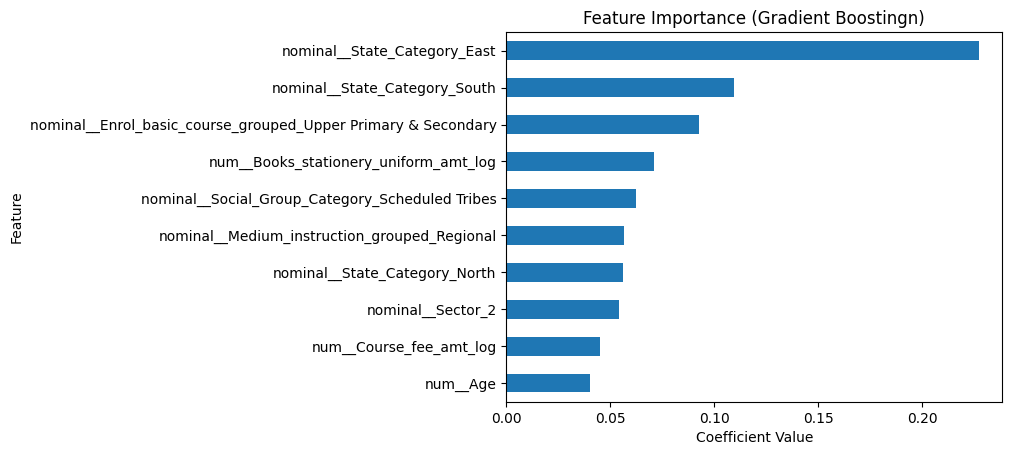

In [ ]:
# Get feature names after transformation
preprocessor = gb.best_estimator_.named_steps["preprocess"]
feature_names = preprocessor.get_feature_names_out()

# Extract coefficients from the Logistic Regression model
importances = gb.best_estimator_.named_steps["classifier"].feature_importances_  # Access coefficients for class 0 (or 1 if binary classification)

# Create a series with feature names and importances (coefficients in this case)
feat_imp = pd.Series(importances, index=feature_names)

# Plot 10 most important features (based on coefficient magnitude)
feat_imp.sort_values().tail(10).plot(kind="barh")
plt.xlabel("Coefficient Value")  # Change label to reflect coefficients
plt.ylabel("Feature")
plt.title("Feature Importance (Gradient Boostingn)");  # Update title for clarity

In [ ]:
feat_imp.sort_values().tail(10)


,0
num__Age,0.040170
num__Course_fee_amt_log,0.045010
nominal__Sector_2,0.054199
nominal__State_Category_North,0.055901
nominal__Medium_instruction_grouped_Regional,0.056759
nominal__Social_Group_Category_Scheduled Tribes,0.062301
num__Books_stationery_uniform_amt_log,0.071130
nominal__Enrol_basic_course_grouped_Upper Primary & Secondary,0.092760
nominal__State_Category_South,0.109272
nominal__State_Category_East,0.227037


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Best Threshold: 0.6080
F1 Score at Best Threshold: 0.5472
Precision: 0.4808
Recall: 0.6351


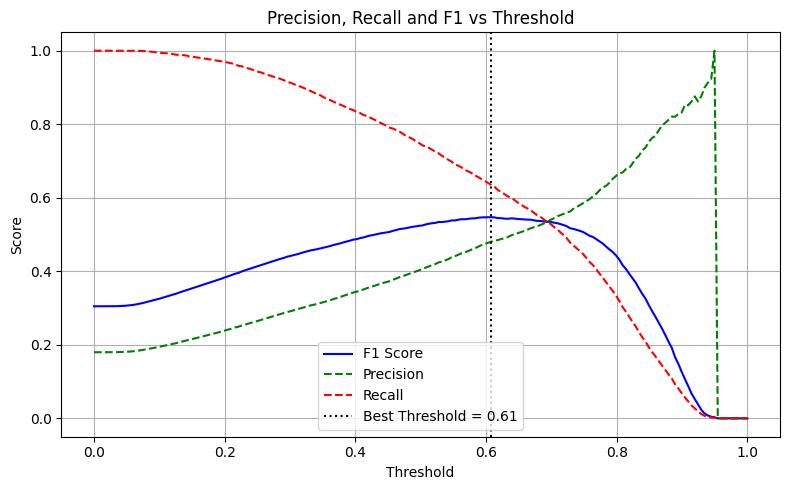

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have:
# y_test = true labels
# y_probs = predicted probabilities (e.g., from model.predict_proba(X_test)[:, 1])

# Create an array of thresholds to test
thresholds = np.linspace(0, 1, 200)
f1_scores = []
precisions = []
recalls = []

# Evaluate F1 at each threshold
for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

# Get the threshold with the best F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best Threshold: {best_threshold:.4f}")
print(f"F1 Score at Best Threshold: {f1_scores[best_idx]:.4f}")
print(f"Precision: {precisions[best_idx]:.4f}")
print(f"Recall: {recalls[best_idx]:.4f}")

# Plot F1 vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1 Score', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='green', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', color='red', linestyle='--')
plt.axvline(best_threshold, color='black', linestyle=':', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall and F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final predictions using best threshold
y_pred_final = (y_probs >= best_threshold).astype(int)
